In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

from skopt import BayesSearchCV
from skopt.space import Real, Integer

from xgboost import XGBClassifier

import json

In [3]:
data = np.load('..\processed_ntuples\chunk_data.npy')
np.shape(data)

(527375, 33)

In [4]:
train, val = train_test_split(data, random_state=137) # setting the seed for reproducibility; the default train/test split is 0.75/0.25
print('lenght of training set', len(train), '\nlenght of validation set', len(val), '\nwidth of the sets: # of features + 1 flag (1-LL/0-TX)', len(train[0]))

lenght of training set 395531 
lenght of validation set 131844 
width of the sets: # of features + 1 flag (1-LL/0-TX) 33


In [5]:
# strip the last feature (e.g. the flag) from the sets

# first line check
print('first train line, before flag-stripping', train[0])

# copy in dedicated arrays
flags_train = train[:, -1]
flags_val = val[:, -1]
# delete from the sets
train = train[:, :-7]
val = val[:, :-7]
# width check
print('width of the samples, after flag-stripping', len(train[0]), len(val[0]))
# first line check
print('first train line, after flag-stripping', train[0])

first train line, before flag-stripping [ 0.45906499 -0.12419549  1.25075436  0.60235751 -0.59819829  0.27543196
 -1.07793952 -2.49373044  1.04359678 -1.1872246   1.79323445 -0.01288755
 -1.31579649 -2.24224946  1.86085179 -0.55318785 -0.36724764  0.91230302
  0.03663595 -0.2697674   0.92358258 -1.12239482 -1.80520892 -1.0771277
 -1.10550845  1.77859855 -0.55486745 -1.46640027  0.02515023  0.11602841
 -1.06045198  0.98780102  0.        ]
width of the samples, after flag-stripping 26 26
first train line, after flag-stripping [ 0.45906499 -0.12419549  1.25075436  0.60235751 -0.59819829  0.27543196
 -1.07793952 -2.49373044  1.04359678 -1.1872246   1.79323445 -0.01288755
 -1.31579649 -2.24224946  1.86085179 -0.55318785 -0.36724764  0.91230302
  0.03663595 -0.2697674   0.92358258 -1.12239482 -1.80520892 -1.0771277
 -1.10550845  1.77859855]


In [6]:
search_space = {
    #'n_estimators': Integer(50, 500),
    'max_depth': Integer(2,8),
    'learning_rate': Real(0.001, 1.0, prior='log-uniform'),
    'subsample': Real(0.5, 1.0),
    'colsample_bytree': Real(0.5, 1.0),
    'colsample_bylevel': Real(0.5, 1.0),
    'colsample_bynode' : Real(0.5, 1.0),
    'reg_alpha': Real(0.0, 10.0),
    'reg_lambda': Real(0.0, 10.0),
    'gamma': Real(0.0, 10.0)
}

xgb = XGBClassifier(eval_metric=['error', 'logloss'], random_state=137)
opt = BayesSearchCV(xgb, search_space, cv=5, n_iter=100, scoring='roc_auc', random_state=137) 
# in reality, you may consider setting cv and n_iter to higher values

In [7]:
opt.fit(train, flags_train, eval_set=[(train, flags_train), (val, flags_val)], verbose=False)
# print(opt.best_score_) # roc-auc
# print(opt.score(val, flags_val))
# print(opt.predict(val))
# print(opt.predict_proba(val))

BayesSearchCV(cv=5,
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None, device=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric=['error', 'logloss'],
                                      feature_types=None, feature_weights=None,
                                      gamma=None, grow_policy=None,
                                      importance_type=None,
                                      interaction...
                             'learning_rate': Real(low=0.001, high=1.0, prior='log-uniform', transform='normalize'),
                             'max_depth': Integer(low=2, high=8, prior='uniform', transform='normalize'),
                             'reg_alpha': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'reg_lambda': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'subsample': Real(low=0.5, high=1.0, prior='uniform', transform='normalize')})

In [8]:
# Saving the xgboost model as a JSON file
model = opt.best_estimator_
results = model.evals_result()
model.save_model('xgb_nonu-model.json')
json.dump(results, open('xgbm_nonu-metrics.json', 'w'))

# # Loading the xgboost model from the JSON file
# model = XGBClassifier()
# model.load_model('xgb_nonu-model.json')
# results = json.load(open('xgbm_nonu-metrics.json'))

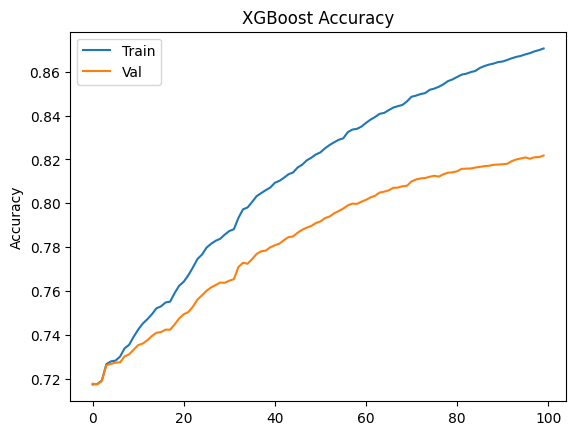

In [9]:
x_axis = range(0, 100)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, [1-x for x in results['validation_0']['error']], label='Train')
ax.plot(x_axis, [1-x for x in results['validation_1']['error']], label='Val')
ax.legend()
plt.ylabel('Accuracy')
plt.title('XGBoost Accuracy')
plt.savefig('acc_nonu-xgb.png')

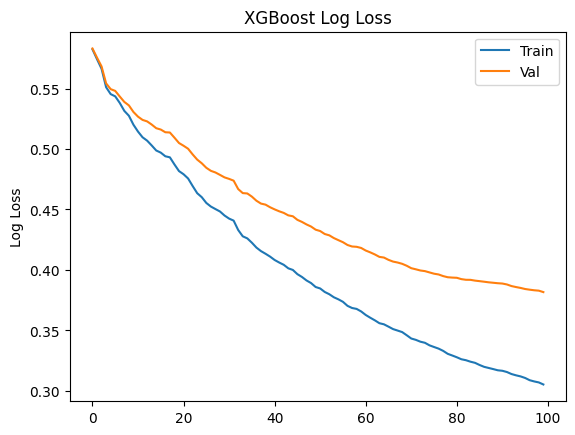

In [10]:
x_axis = range(0, 100)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Val')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.savefig('loss_nonu-xgb.png')

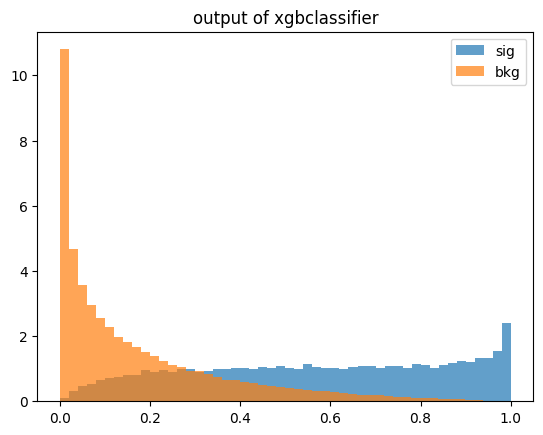

In [11]:
val_outputs = model.predict_proba(val).T[1]
sig = val_outputs[flags_val.T.astype(bool)]
bkg = val_outputs[~flags_val.T.astype(bool)]
plt.hist(sig, bins=50, density=True, alpha=0.7, label='sig')
plt.hist(bkg, bins=50, density=True, alpha=0.7, label='bkg')
plt.legend()
plt.title('output of xgbclassifier')
plt.savefig('output_nonu-xgb.png')

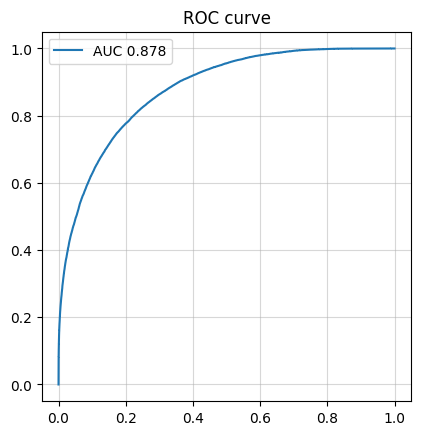

In [12]:
fpr, tpr, thresholds = roc_curve(flags_val, val_outputs)

auc = roc_auc_score(flags_val, val_outputs)

plt.plot(fpr, tpr, label=f'AUC {auc:.3f}')
plt.title(f'ROC curve')
plt.grid(alpha=0.5)
plt.legend()
plt.axis('square')
plt.savefig('ROC_nonu-xgb.png')

In [13]:
#